In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from scipy.ndimage import convolve
import matplotlib.animation as animation
import warnings
import json
import scipy

In [260]:
params = { #parameters relevant for the equations
    "Nh":             100,
    "N0":             100,
    "R0":               4,
    "M":                2, #Also L
    "D":                1, 
    "dc":               5, #Unused
    "mu":             0.1, #Unused
    "gamma_shape":     20,
}
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":         10,
    "dx":               1,
    "t0":               0, 
    "tf":             100,
    "dt":             0.1,
    "noise_mean":       0,
    "noise_std":        1,
    "initial_mean": [0,0],
    "initial_var":      5,
}

In [236]:
x_range = sim_params["xdomain"]
dx = sim_params["dx"]
x_linspace = np.arange(-x_range, x_range, dx)
x_size = np.size(x_linspace)
sim_params["x_size"] = x_size

t_size = (sim_params["tf"]-sim_params["t0"])/sim_params["dt"]

s = np.zeros([x_size, x_size]) # Note this is a continuous simulation
n = np.zeros([x_size, x_size]) # Not nh, n doesn't hate 
h = params["M"]*np.ones([x_size, x_size])/x_size**2
coordmap = np.meshgrid(x_linspace, x_linspace)
c = h.copy()

In [237]:
off_diag = np.ones(x_size**2)
L = scipy.sparse.diags([-1, 5, -1], [-1, 0, 1], shape = (x_size**2, x_size**2)) #Discrete Laplacian Operator L 
L = L.tolil()
L[0,0] = L[-1,-1] = 3 #Neumann Boundary condition
sim_params["Laplacian"] = L #Save it to use later

In [238]:
initial_position = sim_params["initial_mean"] = [0, 0]
initial_var = sim_params["initial_var"] = 1

x_map = coordmap[0]
y_map = coordmap[1]

rsqrd = (x_map-initial_position[0])**2 + (y_map-initial_position[0])**2

n0 = np.exp(-rsqrd/(2*(initial_var**2)))
norm = np.sum(n0)
n0 = n0/np.sum(n0) # initial cond for n: Gaussian dist

h0 = params["M"]*np.ones(h.shape)/np.size(h) # Initial condition for h0: Uniform dist

In [ ]:
def write2json(name):
    with open(name + '_params.json', 'w') as fp:
        json.dump(params, fp)

    with open(name + '_sim_params.json', 'w') as fp:
        json.dump(sim_params, fp)

In [178]:
def coverage(h):
    return h/params["M"]

def normalization(h):
    vmin = np.min(h)
    M = params["M"]

    out = h - vmin
    vtot = np.sum(out)
    out = M*(out/vtot)

    return out

In [179]:
def gen_Gaussian_noise(n):
    mean = sim_params["noise_mean"]
    std = sim_params["noise_std"]
    samples = np.random.normal(mean, std, size=n.size)
    return samples.reshape(n.shape)

In [180]:
n_flat = n.ravel() #ravel is just a pointer change, does not change memory
h_flat = h.ravel() #if you change h, h_flat doesn't change, opposite is not true

In [244]:
def makeGif(frame_stack, name):
    fig = plt.figure()

    animation_frames = []
    for frame in frame_stack:
        frame = np.squeeze(frame)
        animation_frames.append([plt.imshow(frame, animated = True)])
        
    ani = animation.ArtistAnimation(fig, animation_frames, interval=50, blit=True, repeat_delay=1000)
    ani.save(name + ".gif")

    return 1

In [257]:
def step_n_approx(n, h):
    R0 = params["R0"]
    D = params["D"]
    M = params["M"]

    eff_R0 = R0*(1-coverage(h))**M
    drive = np.log(eff_R0, out=np.zeros_like(eff_R0), where=(eff_R0!=0))
    approx_del2 = scipy.ndimage.filters.laplace(n) #Dumb Way to approximate Laplacian
    
    noise = np.sqrt(n)*gen_Gaussian_noise(n)
     
    return drive*n + D*approx_del2 + noise

In [251]:
def step_n_exact(n, h):
    R0 = params["R0"]
    D = params["D"]
    M = params["M"]


    eff_R0 = R0*(1-coverage(h))**M
    drive = np.log(eff_R0, out=np.zeros_like(eff_R0), where=(eff_R0!=0))
    
    L = sim_params["Laplacian"].tocsr() #more exact way to do Laplacian
    
    if n.ndim != 1:
        del2n = L.dot(n.ravel()).reshape(n.shape)
    else:
        del2n = L.dot(n)

    
    noise = np.sqrt(n)*gen_Gaussian_noise(n)
     
    return drive*n + D*del2n + noise

In [183]:
def step_h(n, h):
    Nh = params["Nh"]
    N = np.sum(n) 
    # N = params["N"] #fixed N
    M = params["M"]
    h_new = (1/Nh)*(n - (h/M)*N) 
    return h_new

In [267]:
h = h0
n = n0
t_start = sim_params["t0"]
t_stop = sim_params["tf"]
t_step = sim_params["dt"]

frames_n = []
frames_h = []
N = []

for t in np.arange(t_start, t_stop, t_step):

    n = n + step_n_approx(n, h)*(t_step/2) #Half-step first for n: n(t+dt/2) = n(t) + dn/dt(t)*(dt/2)
    n[n < 0] = 0
    h = h + step_h(n,h)*(t_step/2) #Half-step for h
    h = normalization(h)

    n = n + step_n_approx(n, h)*(t_step/2) #Second Half-step for n : n(t+dt) = n(t+dt/2) + dn/dt(t+dt/2)*(dt/2)
    n[n < 0] =0
    h = h + step_h(n, h)*(t_step/2) #Second Half-step for h
    h = normalization(h)


    frames_n.append([n])
    frames_h.append([h])
    N.append([np.sum(n)])


1

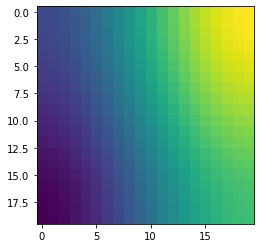

In [271]:
makeGif(frames_h, "continuous_h_approx_high_noise")

In [245]:
def update(n, h, t_step):
    n = n + step_n_exact(n, h)*(t_step) #Half-step first for n: n(t+dt/2) = n(t) + dn/dt(t)*(dt/2)
    n[n < 0] = 0
    # h = h + step_h(n,h)*(t_step) #Half-step for h
    # h = normalization(h)
    return n, h